In [ ]:
from operator import add
from random import choice
from typing import Annotated, Literal

from IPython.display import Image
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field, ValidationError

## TypedDict vs Pydantic

The of the `Literal`keeps the values of the specific set, in the current case it is [green, yellow, red] or None which in the case above the default.

The ruff linter doesn't like Optional, so I changed to the implementation below.

In [ ]:
class State(BaseModel):
    """State model for traffic light color transitions.

    Represents the current and next color of a traffic light in a controlled
    transition process.

    Attributes:
        input_color (Literal): Current color of the traffic light.
            Must be one of "green", "yellow", or "red".
        output_color (Optional[Literal]): Next color after transition.
            Defaults to None until a transition is defined.

    """

    input_color: Literal["green", "yellow", "red"] = Field(
        ...,
        description="Current color of the traffic light. Must be 'green', 'yellow', or\
    'red'.",
        example="green",
    )

    input_color: Literal["green", "yellow", "red"]
    output_color: Literal["green", "yellow", "red"] | None = None

NODE: color_node it is a function (or a Runnable's object) which means a unit of workplace.

In [ ]:
def color_node(state: State) -> dict[str, str]:
    """Node function to determine the next traffic light color.

    Args:
        state (State): The current state containing the input color.

    Returns:
        dict[str, Literal["green", "yellow", "red"]]:
            A dictionary with a single key ``"output_color"`` mapped to a randomly
            chosen traffic light color ("green", "yellow", or "red").

    """
    print(f"input_color: {state.input_color}")
    return {"output_color": choice(["green", "yellow", "red"])}  # noqa: S311

#### Building the workflow
___

1. workflow = StateGraph(State) : Define the State - this step tells LangGraph what the **shape of the state** looks like (what keys/fields exist and their types) 
Only the rules for storing and updating data.
2. add nodes: Each NODE is a function that transforms the state.
3. connect edges : workflow.add_edge(START, "first NODE") -- Edges define **transitions** -- how the workflow moves from one step to the next step.
4. START it is a placeholder for us to decide which NODE(s) should actually run first -- it marks the **entry point**

##### Understand `START` as a Placeholder


a. START doesn’t do any work itself.

b. It simply marks the entry point into the workflow.

c. You must explicitly connect it to the first node(s).

d. This design gives you flexibility: one workflow could have multiple valid entry nodes, depending on your use case.

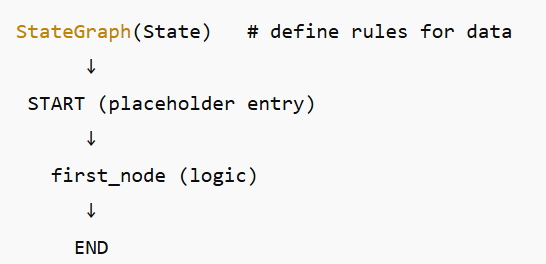

In [ ]:
workflow = StateGraph(State)
workflow.add_node(color_node)  # pyright: ignore[reportUnknownMemberType]
workflow.add_edge(START, "color_node")
workflow.add_edge("color_node", END)

graph = workflow.compile()  # pyright: ignore[reportUnknownMemberType]

In [ ]:
State(input_color="green")

State(input_color='green', output_color=None)

In [ ]:
output = graph.invoke({"input_color": "green"})  # pyright: ignore[reportArgumentType, reportUnknownMemberType]
print(f"output_color: {output['output_color']}")

input_color: green
output_color: yellow


## State Machines

In [ ]:
class State(BaseModel):
    """State model for traffic light controller.

    Args:
        color (Optional[str]): Current color of the traffic light. Must be one of
            "🟢 Green", "🟡 Yellow", or "🔴 Red" if provided.
        repeat_mode (bool): Whether to repeat the traffic light cycle.
        messages (list[str]): List of messages for the controller.
        counter (int): Counter for the number of cycles.

    """

    color: Literal["\U0001f7e2 Green", "\U0001f7e1 Yellow", "🔴 Red"] | None = None
    repeat_mode: bool
    messages: Annotated[list[str], add] = []
    counter: Annotated[int, add] = 0

In [ ]:
def green_light(state: State) -> dict[str, str | list[str] | int]:
    """Handle the green light state for the traffic light controller.

    Args:
        state (State): The current state of the traffic light.

    Returns:
        dict: Dictionary containing the color, messages, and counter.

    """
    color = "🟢 Green"
    wait_time = 60
    message = f"{color} Light! Traffic allowed for {wait_time} seconds..."
    messages = [message]
    # Use state.counter to increment the counter
    counter = state.counter + 1 if hasattr(state, "counter") else 1
    return {"color": color, "messages": messages, "counter": counter}


def yellow_light(state: State) -> dict[str, str | list[str]]:
    """Handle the yellow light state for the traffic light controller.

    Args:
        state (State): The current state of the traffic light.

    Returns:
        dict: Dictionary containing the color and messages.

    """
    color = "🟡 Yellow"
    wait_time = 3
    message = f"{color} Light! Traffic will change in {wait_time} seconds..."
    messages = [message]
    # Optionally, append previous messages if present
    if hasattr(state, "messages") and state.messages:
        messages = state.messages + messages
    return {"color": color, "messages": messages}


def red_light(state: State) -> dict[str, str | list[str]]:
    """Handle the red light state for the traffic light controller.

    Args:
        state (State): The current state of the traffic light.

    Returns:
        dict: Dictionary containing the color and messages.

    """
    counter = state.counter  # pyright: ignore[reportUnusedVariable]
    color = "🔴 Red"
    wait_time = 15
    message = f"{color} Light! Traffic allowed for {wait_time} seconds..."
    messages = [message]
    messages.append("----------------------------------------------------")
    return {"color": color, "messages": messages}

In [ ]:
workflow = StateGraph(State)

In [ ]:
workflow.add_node(green_light)
workflow.add_node(yellow_light)
workflow.add_node(red_light)

In [ ]:
workflow.add_edge(START, "green_light")
workflow.add_edge("green_light", "yellow_light")
workflow.add_edge("yellow_light", "red_light")


def should_repeat(state: State) -> str:
    """Determine whether to repeat the traffic light cycle.

    Args:
        state (State): The current state of the traffic light.

    Returns:
        str: The next node to transition to ("green_light" or END).

    """
    repeat_mode = state.repeat_mode
    counter = state.counter
    if repeat_mode and counter <= 3:
        return "green_light"
    return END


workflow.add_conditional_edges(
    "red_light",
    should_repeat,
    ["green_light", END],
)

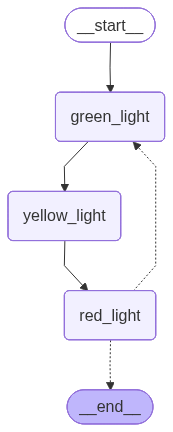

In [ ]:
graph = workflow.compile()  # pyright: ignore[reportUnknownMemberType]

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
print("🚦------------ TRAFFIC LIGHT CONTROLLER ------------🚦")
controller = graph.invoke({"repeat_mode": False})  # type: ignore  # noqa: PGH003
for message in controller["messages"]:
    print(message)

🚦------------ TRAFFIC LIGHT CONTROLLER ------------🚦
🟢 Green Light! Traffic allowed for 60 seconds...
🟢 Green Light! Traffic allowed for 60 seconds...
🟡 Yellow Light! Traffic will change in 3 seconds...
🔴 Red Light! Traffic allowed for 15 seconds...
----------------------------------------------------


### O que você vai aprender nesta demonstração

Nesta demonstração, vamos explorar **como criar e organizar o estado de um workflow no LangGraph**.
Isso será feito em duas etapas principais:

1. **Definição do esquema de estado**

   * Usaremos **TypedDict** para casos mais simples, quando queremos apenas estruturar chaves e valores de forma leve.
   * Usaremos **Pydantic** quando precisarmos de mais robustez, como validações automáticas e garantias de consistência nos dados.

2. **Construção da máquina de estados**

   * Você verá como transformar esses estados em **workflows funcionais**.
   * Primeiro, trabalharemos com **workflows básicos**, ou seja, sequências lineares de etapas.
   * Depois, avançaremos para **ramificações condicionais**, que permitem que o fluxo siga caminhos diferentes de acordo com a lógica do estado.
   * Também aprenderemos a lidar com **fluxos repetitivos** (loops), muito úteis quando queremos que determinadas etapas se repitam até uma condição ser satisfeita.

---

👉 Em resumo: você não só vai entender **como estruturar o estado** da sua aplicação, mas também **como controlar o comportamento dinâmico do workflow** no LangGraph.

---

* TypedDict é útil para fluxos de trabalho simples e flexíveis.
* Pydantic é essencial para fluxos de trabalho robustos e validados.
* `LangGraph` oferece o controle e a flexibilidade necessários para construir fluxos de trabalho reais, com múltiplos caminhos e gerenciamento de estado claro.